In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np
import pandas as pd

# Spreading Factor

The higher the SF parameter is, the longer it takes to send a packet.
As the duty cycle limitation is computed based on the airtime, the higher SF were chosen less often than the lower.


In [79]:
def insert_packet(spreading_factor):
    if spreading_factor < 7:
        return []
    return insert_packet(spreading_factor - 1) + [spreading_factor] + insert_packet(spreading_factor - 1)

sf_as_category = pd.Categorical(insert_packet(12), categories=[7, 8, 9, 10, 11, 12], ordered=True)
pyramid = pd.DataFrame({'SF': sf_as_category})
pyramid['seq_num'] = pyramid.index

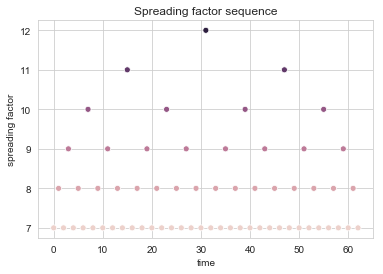

In [27]:
cmap = sns.cubehelix_palette(6)
fig = sns.scatterplot(x=pyramid.index, y='SF', data=pyramid, hue='SF', legend=False, palette=cmap)
fig.set_title('Spreading factor sequence')
fig.set_ylabel('spreading factor')
fig.set_xlabel('time');

In [13]:
pyramid.groupby('SF').count().T

SF,7,8,9,10,11,12
count,32,16,8,4,2,1


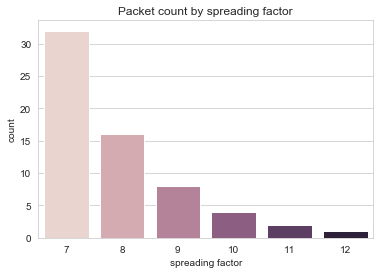

In [29]:
fig = sns.countplot('SF', data=pyramid, palette=cmap)
fig.set_xlabel('spreading factor')
fig.set_title('Packet count by spreading factor');

In [80]:
lorawan_airtime = pd.DataFrame({'SF': [7, 8, 9, 10, 11, 12],
                                'airtime': [54.456, 92.672, 185.344, 329.728, 659.456, 1318.912]})
lorawan_airtime['airtime'] = lorawan_airtime['airtime'] / 1000
packet_sequence = pyramid.merge(lorawan_airtime, on='SF', how='inner').sort_values('seq_num').set_index('seq_num')

,SF,airtime
seq_num,,
0,7,0.054456
1,8,0.092672
2,7,0.054456
3,9,0.185344
4,7,0.054456


In seconds, the daily airtime is equal to

In [131]:
index = pd.timedelta_range(start='0 day', periods=len(packet_sequence.index) * 100, freq='10 min')
tenminute_sequence = packet_sequence
for i in range(99):
    tenminute_sequence = tenminute_sequence.append(packet_sequence)
tenminute_sequence.index = index
tenminute_sequence.resample('1D').sum()['airtime'][0:-1].mean()

19.80593700686498

which is below the fair usage policy of TheThingsNetwork (30 seconds / 24h).

To the contrary, sending a packet every 5 minute would exceed TheThingsNetwork fair usage policy. 